# Análise do Nível de Manutenibilidade
<br>
#### Objetivo:<br>
É importante acompanhar se as issues de correção estão levando mais ou menos tempo, e se o software está com os números de defeitos aumentando ou diminuíndo, ou seja, se a sua modificabilidade está melhorando. Uma boa avaliação desses números é conseguir ter correções mais rápidas e sem efeitos colaterais.
Auxiliar futuras refatorações: Quais devem ser as principais para eliminar problemas;<br>
A partir de uma coleção de métricas coletadas automaticamente e de uma forma objetiva de interpretar seus valores, engenheiros de software podem monitorar características especícas do seu código assim como implementações problemáticas para tomar melhores decisões ao (re)escrevê-las.<br>
<br>
#### Vantagens:<br>
-- Possibilita a rápida identificação de falhas e permite ações de correções na mesma velocidade;<br>
-- O desenvolvimento e a aplicação de novos recursos fica mais fácil e rápido;<br>
-- Há um melhor controle de acesso autorizado para as revisões;<br>
-- Conflitos de mudanças são resolvidos com maior agilidade;<br>
-- Erros e códigos de risco são encontrados mais facilmente;<br>
-- Programadores passam a ter uma visão analítica objetiva, que possibilita e ajuda no reconhecimento de onde os mesmo foram ou não precisos e desatentos;<br>
-- ** Com a exclusão de determinadas classes de defeitos, a equipe se encontra concentrada em outros tipos de eficiência do projeto. **<br>
<br>
Não estou analizando:<br>
-- Complexidade Ciclomática (desvios uma função possui: cada comando if, switch, for, while);<br>
-- Metodos com muitos parâmetros;<br>
-- Outras métricas (Sonar);<br>
<br>
#### Próximos trabalhos:<br>
-- Checkins com uma unit;<br>
-- Cruzar dados do RTC;<br>
<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

arquivos = ['release_changeset_20171.csv', 'HorasPorSalt2017.csv', 'TFS 2017 pas.csv', 'TFS 2017 dfm.csv']
#arquivos = ['release_changeset_2016.csv', 'HorasPorSalt2016.csv', 'TFS 2016 pas.csv', 'TFS 2016 dfm.csv']
#arquivos = ['release_changeset_2013-2015', 'HorasPorSalt2015.csv', 'TFS 2015 pas.csv', 'TFS 2015 dfm.csv']

In [ ]:
dfLinhas = pd.DataFrame({'Metodo' : ['uspjPendenciaPrazo.ConsultaPendencia', 'uspjDBase.ConsultaAtualizacaoInformacoes', 'uspjMensagem.InicializaMensagensSPJ', 'uspjMensagem2.InicializaMensagensSPJ2', 'uspjPendenciaPrazo.AtualizePendencia', 'uspjDocEmitidoServ.OnDepoisSalvarDocumento', 'uspjCDA.OrganizarDadosGeracao', 'uspjProcessoServ.ConsultaProcessoPeloWS', 'uspjPedidoProcurServ.AtualizaPedidoProcurador', 'uspjConsPendenciaPrazoRPdevBasica.PassaParametro', 'uspjCadProcessoMovBase.ccCadastroSpAntesExecutar', 'uspjConsCDA.PreenchaParametrosConsulta', 'uspjAtividadeIndependente.CriarCamposOutrasOperacoes', 'uspjIntimacaoEletServ.ProcessaIntimacao', 'uspjProcessoServ.VerificaConsistenciaProcesso', 'uspjIntimacaoEletServ.ImportarDadosRecebidosWS', 'uspjProcessoMvServ.IncluaMovimentacao'],
                       'Linhas' : [2400, 1100, 1000, 1000, 1000, 900, 800, 800, 700, 700, 650, 580, 550, 540, 500, 500, 500]})
dfLinhas.set_index('Metodo')
print (dfLinhas)

plLinhas = dfLinhas.set_index('Metodo').plot(kind='barh')
plt.title("Número de linhas por método")
plt.show()

print ("*** Algumas fontes a média de linhas por metodo é considerado ruim acima de 13.");


In [ ]:
dfHeadlistPas = pd.read_csv(arquivos[2], encoding='ISO-8859-1', delimiter=',')
#dfHeadlistPas = dfHeadlistPas.drop('cfi', axis=1)
dfHeadlistPas = dfHeadlistPas.query('quantum > 15')
dfHeadlistPas = dfHeadlistPas.assign(file=dfHeadlistPas['itemName'].str.split("/"))
#dfHeadlistPas['file'] = dfHeadlistPas['file'][-1]
#dfHeadlistPas['file'][0][-1]

#f = lambda x: len(x["review"].split("disappointed")) -1
#reviews["disappointed"] = reviews.apply(f, axis=1)

files = []
for row in dfHeadlistPas['itemName']:
    files.append(row.split('/')[-1])
dfHeadlistPas['file'] = files
dfHeadlistPas = dfHeadlistPas.drop('itemName', axis=1).drop('cfi', axis=1)
dfHeadlistPas

In [ ]:
plLinhas = dfHeadlistPas.drop('size', axis=1).set_index('file').plot(kind='barh')
plt.title("Checkins no ano por Unit")
plt.show()

In [ ]:
plLinhas = dfHeadlistPas.drop('quantum', axis=1).sort_values(by='size').set_index('file').plot(kind='barh')
plt.title("Tamanho da Unit")
plt.show()

In [ ]:
dfHeadlistDfm = pd.read_csv(arquivos[3], encoding='ISO-8859-1', delimiter=',')
#dfHeadlistDfm = dfHeadlistPas.drop('cfi', axis=1)
dfHeadlistDfm = dfHeadlistDfm.query('quantum > 2')
dfHeadlistDfm = dfHeadlistDfm.assign(file=dfHeadlistDfm['itemName'].str.split("/"))
#dfHeadlistDfm['file'] = dfHeadlistPas['file'][-1]
#dfHeadlistDfm['file'][0][-1]

#f = lambda x: len(x["review"].split("disappointed")) -1
#reviews["disappointed"] = reviews.apply(f, axis=1)

files = []
for row in dfHeadlistDfm['itemName']:
    files.append(row.split('/')[-1])
dfHeadlistDfm['file'] = files
dfHeadlistDfm = dfHeadlistDfm.drop('itemName', axis=1).drop('cfi', axis=1)
dfHeadlistDfm

In [ ]:
plLinhas = dfHeadlistDfm.drop('size', axis=1).set_index('file').plot(kind='barh')
plt.title("Checkins no ano por dfm")
plt.show()

<http://sonarunj/components/index/9848>

***
### Changeset

Extraido do TFS:<br>
```python
tf hist /noprompt /recursive /format:detailed /version:D"1/1/2015"~D"31/12/2015" $/fPJ/PJ/build/release > 
```


** Utilizado arquivo TFS.ipynb para conversão em CSV.

In [2]:
dfChangesets = pd.read_csv(arquivos[0], encoding='ISO-8859-1', delimiter=';', header=None, 
                 names= ["Salt", "Changeset", "Desenv", "Data", "Descricao", "File", "Filename"])
dfChangesets.head(5)
#df.describe()
#dfChangesets.describe()
#dfChangesets.shape
#dfChangesets.dtypes

,Salt,Changeset,Desenv,Data,Descricao,File,Filename
0,0/0,553789,felipe.caputo,27/12/2017,Implementada invalidação de cache para quando ...,uintCommon.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...
1,0/0,553789,felipe.caputo,27/12/2017,Implementada invalidação de cache para quando ...,uintWsProcessadorConsultarTeorComunicacao.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...
2,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,dbChange.xml,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...
3,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...
4,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...


['felipe.caputo' 'emerson.db1' 'robledo.fortuna' 'anderson.albuquerque'
 'darlley.silva' 'nimitz' 'orlando.werner' 'murilo.guollo' 'cassio.roos'
 'andre.langner' 'wilian.ivo' 'juliano' 'carlos.ignacio' 'ulisses.campos'
 'taissiane.moroso' 'guilherme.araujo' 'Rigoni' 'fabio.schunig'
 'valdenir.albino' 'robson.db1' 'roni.beltramin' 'william.colombo' 'versao'
 'luhan.silva' 'gessileini.clinio' 'cesar.pamplona' 'henrique.ramos'
 'rafael.wagner' 'rafael.damasco' 'mathias.silva' 'romulo' 'celio.assis'
 'ulder.junior' 'cesar' 'leandro.vaso' 'maciel.zang' 'rafael.db1'
 'luiz.db1' 'raphael.batista' 'christian.salinas' 'adriane.col'
 'francisco.gomes' 'luiz.faria' 'roberto.junior' 'jefferson.pereira'
 'joel.zurawski' 'joao.taraciuk' 'douglas.zuliani' 'daniel.junior'
 'michelle.sander' 'polegato' 'johnathan.vieira' 'willian.reis']


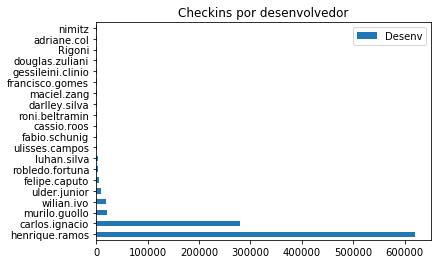

In [3]:
Desenvs = dfChangesets.Desenv.unique()
def GraficoDesenv(df):
    print (Desenvs)
    Files = df.Desenv.value_counts().to_frame() #index #.tolist()
    Files[:20].plot(kind='barh')
    plt.title("Checkins por desenvolvedor")
    plt.show()
    
GraficoDesenv(dfChangesets)

In [4]:
DB1 = ['emerson.db1', 'robson.db1', 'rafael.db1', 'raphael.batista', 'luiz.db1']
Evolucao = ['robledo.fortuna', 'orlando.werner', 'cassio.roos', 'andre.langner', 'juliano', 'guilherme.araujo', 'fabio.schunig' 'ulisses.campos', 'valdenir.albino', 'adriane.col', 'roberto.junior'  'joel.zurawski', 'polegato','rafael.wagner', 'maciel.zang']
Correcao = ['anderson.albuquerque', 'darlley.silva', 'murilo.guollo', 'wilian.ivo', 'gessileini.clinio', 'william.colombo', 'roni.beltramin', 'cesar.pamplona', 'taissiane.moroso', 'douglas.zuliani', 'francisco.gomes'] 
Mni = ['luhan.silva', 'jefferson.pereira', 'felipe.caputo']
Outros = ['nimitz', 'romulo', 'ulder.junior', 'Rigoni']

In [5]:
def Equipe(d): #desenv
    if d in DB1:
        return 'DB1'
    if d in Evolucao:
        return 'Evolucao'
    if d in Correcao:
        return 'Correcao'
    if d in Mni:
        return 'Mni'
    if d in Outros:
        return 'Outros'

dfChangesets['Equipe'] = dfChangesets.Desenv.apply(Equipe)

In [ ]:
#df.groupby('File').count()
#Files = df.File.value_counts()
Files = dfChangesets.File.value_counts().to_frame() #index #.tolist()
Files = Files.filter(like='.pas', axis=0)

Files[:20].plot(kind='barh')
plt.title("Checkins por unit")
plt.show()

# Salts

Dados exportados do SAC via SQL.<br>

> OndeDrive/SAC/Horas.sql
```sql
SELECT DISTINCT 
       ia.NUATENDIMENTO,
       IA.NUITEM,
     ia.NUATENDIMENTO || '/' || IA.NUITEM AS SALT,
       RA.CDORIGEMATEND AS ORIGEM,
       --ra.NUSEQVERSAO,
       ve.NURELEASE,
       /*(SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE = 120) AS PRIORIDADES_SOLICITADAS,
       CASE WHEN IA.DTLIMSOLUCAO < CURRENT DATE THEN 'VENCIDA' ELSE 'DENTRO_PRAZO' END SITUACAO_SLA,*/
       CLI.SGCLIENTE AS CLIENTE,
       IA.DTREGISTRO AS DATA_CADASTRO,
       IA.DTLIMSOLUCAO AS DATA_SLA,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 'ZERO/CRÍTICA'
         WHEN 5 THEN 'UM/IMPEDITIVA'
         WHEN 1 THEN 'DOIS/ALTA'
         WHEN 2 THEN 'TRES/MÉDIA'
         WHEN 3 THEN 'QUATRO/BAIXA'
         WHEN 4 THEN 'INDEFINIDA'
       END SEVERIDADE,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 8
         WHEN 5 THEN 5
         WHEN 1 THEN 4
         WHEN 2 THEN 3
         WHEN 3 THEN 2
         WHEN 4 THEN 3
       END PONTUACAO_SEVERIDADE,
       SIT.DESITUACAOATEND AS SITUACAO_SALT,
       /*CASE WHEN (SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE IN (243,303)) > 0 THEN 'SIM' ELSE 'NÃO' END AS REJEITE,*/
       AA.NUSEQATIVIDADE,
       AA.CDTIPOATIVIDADE,
       TA.DETIPOATIVIDADE,
       AA.DTREALINICIO,
       AA.DTREALFINAL,
       '0' || CAST(AA.QTHORASREAL AS VARCHAR(10)) AS QTHORASREAL,
    (SELECT '0' || CAST(SUM(AA.QTHORASREAL) AS VARCHAR(10))
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  --AND AA.CDTIPOATIVIDADE IN (243,303)
                  ) AS HORASTOTAIS
  FROM sac.ESACREGISTROATEND ra
 LEFT JOIN sac.ESACVERSAO ve
    ON ra.CDPROJETO = ve.CDPROJETO
   AND ra.CDSISTEMA = ve.CDSISTEMA
   AND ra.NUSEQVERSAO = ve.NUSEQVERSAO
  JOIN sac.ESACITEMATEND ia
    ON ia.cdProjeto = ia.CDPROJETO
   AND ia.NUATENDIMENTO = ra.NUATENDIMENTO
  JOIN SAC.ESACSITUACAOATEND SIT
    ON SIT.CDSITUACAOATEND = IA.CDSITUACAOATEND
  JOIN sac.ESACATIVIDADE a
    ON a.cdProjeto = ia.CDPROJETO
   AND a.NUATENDIMENTO = ia.NUATENDIMENTO
   AND a.NUITEM = ia.NUITEM
   AND a.CDTIPOATIVIDADE in (162)
  JOIN SAC.ESACCLIENTE CLI
    ON CLI.CDCLIENTE = ra.CDCLIENTE    
  JOIN SAC.ESACATIVIDADE AA
    ON AA.CDPROJETO = IA.CDPROJETO
   AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
   AND AA.NUITEM = IA.NUITEM    
 LEFT  JOIN SAC.ESACTIPOATIVIDADE TA
    ON AA.CDTIPOATIVIDADE = TA.CDTIPOATIVIDADE
 WHERE ra.cdProjeto = 3
--   AND ra.CDORIGEMATEND = 10
   AND ra.CDSISTEMA IN (31,93)
--   AND ra.CDCLIENTE <> 3969
--   AND a.DTENCERRAMENTO IS NULL
--   AND ia.DTLIMSOLUCAO IS NOT NULL
--   AND SIT.CDSITUACAOATEND=65
   AND VARCHAR_FORMAT (ia.DTREGISTRO,'YYYY-MM-DD') > '2017-01-01'
--AND ra.NUATENDIMENTO = 263466
ORDER BY ia.NUATENDIMENTO, IA.NUITEM, AA.NUSEQATIVIDADE
```


In [6]:
dfSalts = pd.read_csv(arquivos[1], encoding='ISO-8859-1', delimiter=',')
dfSalts

,NUATENDIMENTO,NUITEM,SALT,ORIGEM,NURELEASE,CLIENTE,DATA_CADASTRO,DATA_SLA,SEVERIDADE,PONTUACAO_SEVERIDADE,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS
0,4,2,4/2,8,03020100,EQUIPE-SAJ,2017-03-02 16:59:16,NaN,UM/IMPEDITIVA,5,Pendente,1,310,Apontamento de Horas,2017-03-02,2017-03-02,0.016,0.016
1,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-05-11 13:39:16,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,0.750,0.750
2,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,2,16,Avaliação do atendimento,2017-01-18 17:46:04,2017-01-18 17:46:04,3.500,4.500
3,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,3,283,Revisão de código,2017-01-18,2017-01-18,1.000,4.500
4,1003,1,1003/1,8,03030101,EQUIPE-SAJ,2017-05-11 16:46:57,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,0.750,0.750
5,1003,1,1003/1,8,03030101,EQUIPE-SAJ,2017-01-20 15:21:58,NaN,UM/IMPEDITIVA,5,Encerrado,2,16,Avaliação do atendimento,2017-02-01,2017-02-01,1.000,1.000
6,12110,1,12110/1,8,02000000,EQUIPE-SAJ,2017-04-03 10:11:10,NaN,INDEFINIDA,3,Encerrado,1,16,Avaliação do atendimento,2017-04-05,2017-04-05,0.016,0.016
7,12117,1,12117/1,8,02000001,EQUIPE-SAJ,2017-04-26 16:06:22,NaN,TRES/MÉDIA,3,Encerrado,1,918,Atendimento ao Cliente/Suporte,2017-04-26 16:08:14,2017-04-26 16:08:14,0.500,0.500
8,12149,1,12149/1,10,01000304,PGE/PB,2017-10-25 15:02:54,2017-10-31 15:01:59,INDEFINIDA,3,Encerrado,1,918,Atendimento ao Cliente/Suporte,2017-10-20 15:03:47,2017-10-20 15:03:47,1.000,1.000
9,54056,1,54056/1,10,03030704,PGE/SP,5006-08-31,NaN,TRES/MÉDIA,3,Encerrado,1,77,Cadastro do atendimento,2006-09-04,2006-09-04,0.116,0.449


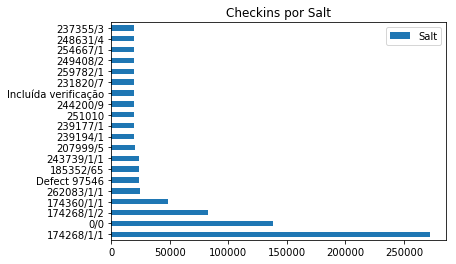

In [10]:
Salts = dfChangesets.Salt.value_counts().to_frame() #index #.tolist()
#Files[:20].plot(kind='barh')
#Files = Files.filter(like='.pas', axis=0)

Salts[:20].plot(kind='barh')
plt.title("Checkins por Salt")
plt.show()

In [ ]:
Salts = dfChangesets.Salt.value_counts()#.to_frame()
Salts = Salts.loc[Salts>1050]
Salts = Salts.to_frame().reset_index()
Salts = Salts.drop('Salt', axis=1)
Salts = Salts.set_index("index")
Salts

In [7]:
Salts_counts = dfChangesets.Salt.value_counts()
#Salts_uniques = dfChangesets.Salt.unique()#.to_frame()

dfChangesets['conta'] = dfChangesets.Salt.apply(lambda y: 1 if y not in Salts_counts else Salts_counts[y])
dfChangesets['apagar'] = dfChangesets.conta.apply(lambda y: True if y>1050 else False)

In [8]:
dfChangesets = dfChangesets[dfChangesets.apagar == False]

['felipe.caputo' 'emerson.db1' 'robledo.fortuna' 'anderson.albuquerque'
 'darlley.silva' 'nimitz' 'orlando.werner' 'murilo.guollo' 'cassio.roos'
 'andre.langner' 'wilian.ivo' 'juliano' 'carlos.ignacio' 'ulisses.campos'
 'taissiane.moroso' 'guilherme.araujo' 'Rigoni' 'fabio.schunig'
 'valdenir.albino' 'robson.db1' 'roni.beltramin' 'william.colombo' 'versao'
 'luhan.silva' 'gessileini.clinio' 'cesar.pamplona' 'henrique.ramos'
 'rafael.wagner' 'rafael.damasco' 'mathias.silva' 'romulo' 'celio.assis'
 'ulder.junior' 'cesar' 'leandro.vaso' 'maciel.zang' 'rafael.db1'
 'luiz.db1' 'raphael.batista' 'christian.salinas' 'adriane.col'
 'francisco.gomes' 'luiz.faria' 'roberto.junior' 'jefferson.pereira'
 'joel.zurawski' 'joao.taraciuk' 'douglas.zuliani' 'daniel.junior'
 'michelle.sander' 'polegato' 'johnathan.vieira' 'willian.reis']


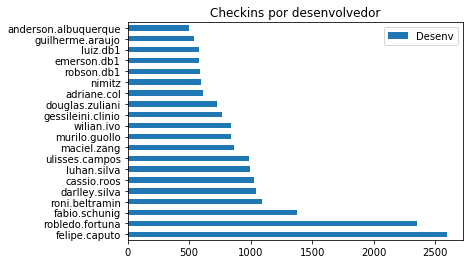

In [9]:
GraficoDesenv(dfChangesets)

In [13]:
dfChangesets.groupby('Salt')['Salt'].count()

Salt
0                       112
0000/0                    3
0\0                       2
1                         2
101380                   19
103043                    1
104466/102                3
104466/109                7
104466/114               43
104466/116                3
104466/117                5
104466/118                1
104466/119               25
104466/120                6
104466/121                6
104466/123               23
106307                    1
106356                    3
107980                    4
110250-1                  1
110250/1                  4
110356                    5
111882                    2
113364                    2
118603/4                  8
119066                    4
1234567/8                 1
12345678/1                1
142314/2                  1
148939/109               14
                       ... 
Defect 97987              1
Defect 97989              3
Defect 98210              1
Defect 98301              5
Defect 98414   

In [35]:
#dfChangesets['conta'] = 0
dfChangesets['conta'] = dfChangesets.groupby('Salt')['Salt'].count()
dfChangesets.groupby('Salt')['Salt'].count()

Salt
1000/1         3
1003/1         2
102892/4      14
104466/116     9
104466/117    15
104466/118     2
104466/119    75
104466/120    18
104466/121    18
104466/122    43
104466/123    23
104466/125     3
104466/126     6
104466/127     5
106600/1      11
106602/1       8
106605/1       1
106611/1      34
106614/1      10
106621/1       9
106628/1       1
106638/1      22
106643/1       1
106648/1       9
106649/1       4
106652/1       9
106666/1      16
106677/1       6
106678/1       9
106680/1       8
              ..
75622/1        1
75626/1        1
75627/1        1
75635/1        1
75644/1        1
75647/1        1
75654/1        1
75659/1        1
75663/1        1
75673/1        1
75688/1        1
75690/1        1
75691/1        1
75699/1        1
75713/1        1
75720/1        1
75721/1        1
75724/1        1
75725/1        1
75727/1        1
75737/1        1
75749/1        1
75750/1        1
75759/1        1
75760/1        1
75767/1        1
75768/1        1
75771/1  

In [10]:
dfChangesets.head(30)

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Equipe,conta,apagar
2,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,dbChange.xml,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
3,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
4,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
5,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55,False
6,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadConfiguracaoProcAdministrativosPrecator...,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
7,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadConfiguracaoProcAdministrativosPrecator...,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
8,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadCriterioDistComOrgao.dfm,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
9,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadCriterioDistComOrgao.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
10,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadProcessoAdmMov.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False
11,247275/4,553788,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjConsultaAcordosPrecatorioNaoProcessados.dfm,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55,False


In [11]:
dfSalts['Salt'] = dfSalts.SALT
dfChangesets = dfChangesets.merge(dfSalts[['Salt','HORASTOTAIS']], how='right', on='Salt')

In [12]:
dfChangesets.query('conta > 1')

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Equipe,conta,apagar,HORASTOTAIS
0,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,dbChange.xml,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55.0,False,21.000
1,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55.0,False,21.000
2,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55.0,False,21.000
3,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,PJ011829.DH4,/fPJ/PJ/build/release/4.20/servicepack/pjDev/d...,DB1,55.0,False,21.000
4,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadConfiguracaoProcAdministrativosPrecator...,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55.0,False,21.000
5,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadConfiguracaoProcAdministrativosPrecator...,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55.0,False,21.000
6,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadCriterioDistComOrgao.dfm,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55.0,False,21.000
7,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadCriterioDistComOrgao.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55.0,False,21.000
8,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjCadProcessoAdmMov.pas,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55.0,False,21.000
9,247275/4,553788.0,emerson.db1,27/12/2017,SALT 247275/4 - Feature 121967 - [24] - Distri...,uspjConsultaAcordosPrecatorioNaoProcessados.dfm,/fPJ/PJ/build/release/4.20/servicepack/pjDev/s...,DB1,55.0,False,21.000


In [15]:
dfChangesets['Media'] = dfChangesets.conta / dfChangesets.HORASTOTAIS

In [16]:
HorasFile = dfChangesets[dfChangesets.Equipe == 'Correcao'].groupby('File', as_index=False).agg({"Media": "sum"})
HorasFile.sort_values(by='Media', ascending=False).head(100)

,File,Media
414,uspjIntimacaoeletServ.pas,11287.511075
476,uspjProcessamentoAtoEletronico.pas,9658.238561
317,uspjDistpendenciaServ.pas,7651.391846
314,uspjDistProcessoServ.pas,6770.280710
347,uspjExecucaoAtoEletronico.pas,5953.665520
477,uspjProcesso.pas,5936.498664
313,uspjDistProcesso.pas,5576.942048
481,uspjProcessoServ.pas,5452.919729
335,uspjDocEmitidoServ.pas,4555.799989
574,uspjVinculacaoProcessoAtoEletronico.pas,3461.779186


In [17]:
correcao = dfChangesets[dfChangesets.Equipe == 'Correcao']
correcao[correcao.File == 'DIG000082.DH4']

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Equipe,conta,apagar,HORASTOTAIS,Media
79229,250939/1,533238.0,cesar.pamplona,15/8/2017,SALT 250939-1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79230,250939/1,533238.0,cesar.pamplona,15/8/2017,SALT 250939-1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79231,250939/1,533238.0,cesar.pamplona,15/8/2017,SALT 250939-1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79243,250939/1,532626.0,cesar.pamplona,11/8/2017,SALT 250939/1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79244,250939/1,532626.0,cesar.pamplona,11/8/2017,SALT 250939/1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79245,250939/1,532626.0,cesar.pamplona,11/8/2017,SALT 250939/1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79265,250939/1,533238.0,cesar.pamplona,15/8/2017,SALT 250939-1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79266,250939/1,533238.0,cesar.pamplona,15/8/2017,SALT 250939-1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79267,250939/1,533238.0,cesar.pamplona,15/8/2017,SALT 250939-1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694
79279,250939/1,532626.0,cesar.pamplona,11/8/2017,SALT 250939/1 - Criar índices para os campos d...,DIG000082.DH4,/fPJ/PJ/build/release/4.22/servicepack/pjDev/s...,Correcao,36.0,False,22.703,1.585694


In [67]:
dfSalts.groupby(['CDTIPOATIVIDADE', 'DETIPOATIVIDADE'])['Salt'].count().to_frame().sort_values(by='Salt', ascending=False)
#dfAtividades

#dfChangesets['HorasDesenv'] = dfChangesets.Desenv.apply(lambda y: 0 if y not in Desenv else Salts_counts[y])

#dfSalts.groupby(['Salt', '']).agg({'duration': [min, max, sum],      # find the min, max, and sum of the duration column
#                                     'network_type': "count", # find the number of network type entries
#                                     'date': [min, 'first', 'nunique']})    # 

83	Determinacao das Causas Possiveis
162	Avalicao atendimento - Correcao
51	Sincronizacao de fontes para versao de correcao
188	Avaliacao atendimento - Desenvolvimento PJ
90	Suporte e apoio t้cnico ao cliente interno
336	Codificar solucao
8	Codificacao
45	Codificacao devido a testes reprovados
119	Avaliacao atendimento - Desenvolvimento
15	Script
344	Corrigir codificacao


,,Salt
CDTIPOATIVIDADE,DETIPOATIVIDADE,
244,Roteamento Suporte,8131
302,Aguardando aceite final,6887
654,Avaliação atendimento - Suporte,5881
83,Determinação das Causas Possíveis,4443
16,Avaliação do atendimento,3340
162,Avaliação atendimento - Correção,2611
682,Avaliação N1,2034
17,Aguardando cliente,1886
644,Ag. aceite - Cancelamento,1694


In [ ]:
# quantidade de horas por unit (dividindo igualmente por unit)

#filtrar os defects e corrigir com o número da salt (também remove salts NaN)
#para isso gerar um arquivo no RTC: defect|salt|colaborador|horas

# verificar deixar apenas atividades de desenv
#Salts que estouraram por unit
#Salts por por severidade por unit

----------------------------------------------
#df_filtered = dfSalts[dfSalts['SALT'] == '12149/1']
#df_filtered

#dfSalts.DETIPOATIVIDADE.unique()

----------------------------------------------

#dfAtividades['QTHORASREAL'].aggregate(np.sum).to_frame()
----------------------------------------------

dfChangesetsArray = dfChangesets
dfChangesetsArray.set_index('Salt');
#dfChangesets[(dfChangesetsArray.Salt[:6] == 'Defect')]
#dfChangesets = dfChangesetsArray.mask(lambda x: x['Salt'][:6] == 'Defect')
#dfChangesets = dfChangesetsArray.Salt.str.contains('Defect')
#dfChangesets = dfChangesetsArray.Salt.str.startswith( )
dfChangesetsArray = dfChangesetsArray.Salt.str.contains('/')

dfChangesets[dfChangesetsArray]#dfChangesets = 
#dfChangesets
GraficoDesenv(dfChangesets[dfChangesetsArray])

